In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

In [2]:
class TCN(nn.Module):
    def __init__(self, T_no, hid_no, device):
        super().__init__()
        
        self.T_no = T_no
        self.device = device
        self.hid_no = hid_no
        
        self.tcn = nn.Sequential(
            nn.Conv1d(in_channels=240,
                     out_channels=self.hid_no,
                     kernel_size=self.T_no,
                     padding=self.T_no//2,
                     groups=1),
            nn.LeakyReLU(),
            #nn.Conv1d(in_channels=self.hid_no,
                     #out_channels=self.hid_no,
                     #kernel_size=self.T_no,
                     #padding=self.T_no//2,
                     #groups=self.hid_no),
            #nn.LeakyReLU(),
            nn.Conv1d(in_channels=self.hid_no,
                     out_channels=1,
                     kernel_size=self.T_no,
                     padding=self.T_no//2),
            nn.Softplus()
        )
                
        self.C_den = torch.zeros(self.hid_no, 240).to(self.device)
        g = 240//self.hid_no
        for i in range(self.hid_no):
            self.C_den[g*i:(i+1)*g] = 1
            
        #self.step = Step.apply
        
        #self.Tau = nn.Parameter(torch.zeros(1) , requires_grad=True)
        #self.Tau = torch.ones(1).to(self.device)*2
        #self.W = nn.Parameter(torch.zeros(1) , requires_grad=True)
        
    def forward(self, S):
        #S_in = torch.matmul(S, self.C_den.T).T.unsqueeze(0)
        S_in = S.T.unsqueeze(0)
        out = self.tcn(S_in)
        out = out.flatten()
        V = out
        #out = self.step(out)
        
        #t = torch.arange(self.T_no).to(self.device)
        #t_tau = t / torch.exp(self.Tau)
        #kern = t_tau * torch.exp(-t_tau) * torch.exp(self.W)
        #kern = torch.flip(kern, [0])
        
        #V = F.conv1d(out.reshape(1,1,-1), kern.reshape(1,1,-1), padding=self.T_no//2).flatten()
        
        return V
    
    
class Step(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        zero = torch.tensor([0.0]).cuda()
        return torch.heaviside(input, zero)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        derivative = 1/(1+torch.abs(input))**2
        output = derivative * grad_input
        return output

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
#I_neural_file = "Ispikes_neural.npy"
V_file = "V_diff.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)[:,880:1120]
#I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)

E_neural = torch.from_numpy(E_neural)
#I_neural = torch.from_numpy(I_neural)
V = torch.from_numpy(V)

#####
V[V < 0.3] = 0

In [4]:
T_train = 8 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 51
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")
hid_no = 4

batch_size = 50000
iter_no = 10000
epoch_no = iter_no*batch_size//T_train 


In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
#test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
#train_I_neural = I_neural[:T_train].float()

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    #part_idx = np.arange(T_train - batch_size)
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = TCN(T_no, hid_no, device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

49169


In [7]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    #batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred = model(batch_E_neural)
        
    train_mse = torch.mean((V_pred - batch_V)**2)
    train_var = torch.var(V_pred - batch_V)
    train_score = explained_variance_score(batch_V.cpu().detach().numpy(), V_pred.cpu().detach().numpy())
    
    reg2 = 0
    reg1 = 0
    for param in model.parameters():
        reg2 += torch.sum(param**2)
        reg1 += torch.sum(torch.abs(param))
    
    #loss = train_var + 0.00001*reg1
    loss = train_mse + 0*reg2
    
    loss.backward()
    optimizer.step()
    
    if i%100 == 99:
        model.eval()
        test_V_pred = model(test_E_neural) 
         
        test_mse = torch.mean((test_V_pred - V_test)**2).item()
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        
        print(i, np.round(test_score, 6),
              np.round(test_mse, 6),
              np.round(train_score.item(), 6),
              np.round(train_mse.item(), 6)
              #torch.sum(test_Z_pred).item(),
             #model.W_out.item(),
             #model.Tau_out.item()
             )


<ipython-input-7-d7b039f9b383>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


99 -0.720526 0.065745 -0.648905 0.072243
199 -0.171885 0.026625 -0.179128 0.023002
299 -0.094721 0.02367 -0.09571 0.020013
399 -0.0654 0.022823 -0.059709 0.021559
499 -0.05018 0.022463 -0.041185 0.029926
599 -0.041037 0.022278 -0.033278 0.029725
699 -0.035036 0.022172 -0.031969 0.02639
799 -0.030862 0.022107 -0.032144 0.023047
899 -0.027994 0.022065 -0.010359 0.025205
999 -0.025908 0.022035 0.0045 0.024852
1099 -0.02422 0.022006 0.101925 0.018268
1199 -0.024273 0.021997 0.060145 0.023458
1299 -0.006689 0.021591 0.317358 0.01222
1399 -0.015478 0.021729 0.28366 0.015946
1499 -0.117692 0.023909 0.529939 0.008427
1599 -0.244562 0.026621 0.375501 0.01389



KeyboardInterrupt: 

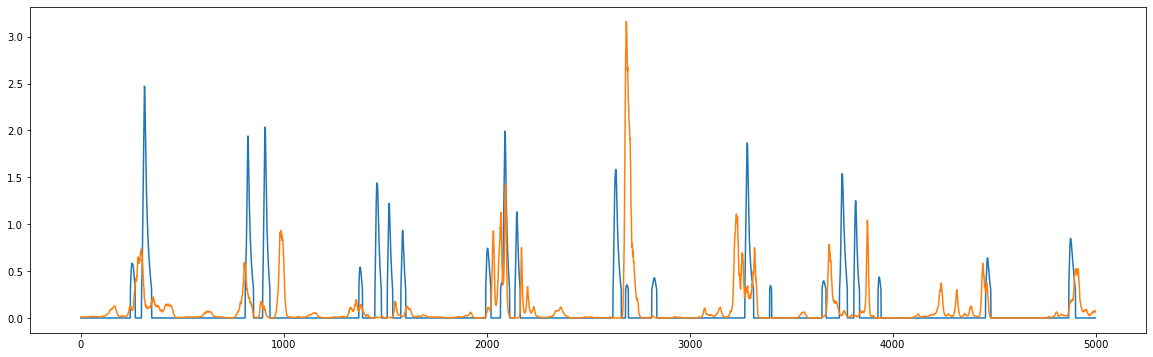

In [12]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy()[15000:30000][3000:8000])
plt.plot(test_V_pred.cpu().detach().numpy()[15000:30000][3000:8000])


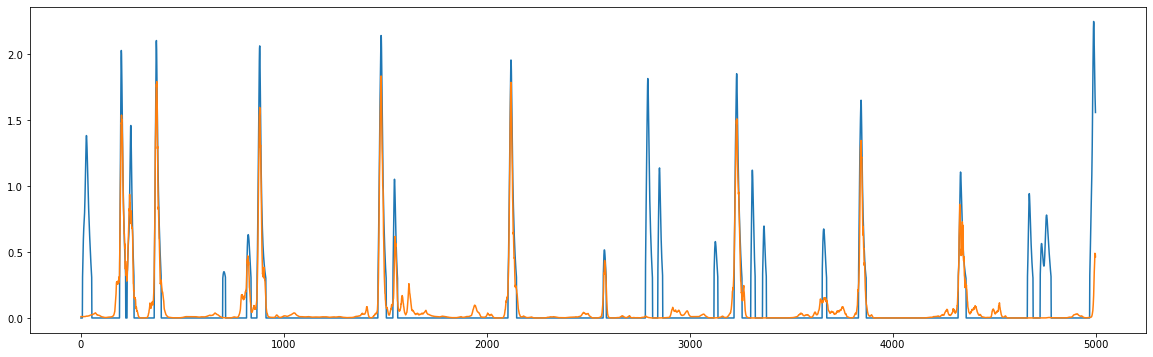

In [13]:
plt.figure(figsize=(20,6))
plt.plot(batch_V.cpu().detach().numpy()[15000:30000][3000:8000])
plt.plot(V_pred.cpu().detach().numpy()[15000:30000][3000:8000])